К вопросу https://ru.stackoverflow.com/questions/1289610

Всем привет. Мне нужен анализатор спектра в реальном времени как в звуковых плеерах. На языке python. Код для чтение wav файла и fft готов, но не понимаю как строить "столбики звука". Пробовал через matplotlib. Нечего не вышло. Заранее спасибо.

In [1]:
import numpy as np
from scipy.io.wavfile import read as wavread

Пример трека - 60 секунд Имперского марша из Звёздных войн.

In [2]:
sampling_rate, data = wavread("ImperialMarch60.wav")

Трек одноканальный, общее число замеров кратно частоте дискретизации.

In [3]:
data.shape[0] % sampling_rate

0

Я не знаю, что именно показывают анализаторы спектра в своих столбиках. 

Поэтому своим произволом решил, что они показывают удельную энергию, приходящуюся на диапазон. Возможно, это не так. Тогда нужно вместо функции `bandpower` использовать соответствующую агрегирующую функцию

In [4]:
def bandpower(samples, sampling_rate, freq_ranges):
    """Функция возвращаем массив, каждый элемент которого есть удельная энергия, приходящаяся на заданный интервал частот.
    samples - массив амплитуд сигнала (например, из wav файла).
    sampling_rate - частота дискретизации.
    freq_ranges - списко частот, ограничивающих интервалы.
    """
    result = []
    # Преобразование Фурье, оптимизированная функция для вещественных значений
    fft_data = np.abs(np.fft.rfft(samples))
    fft_data_sq = fft_data*fft_data
    # У этой функции нет отрицательных значений частот
    fft_freqs = np.fft.rfftfreq(len(samples), d=1.0/sampling_rate)
    for f1, f2 in zip(freq_ranges[:-1], freq_ranges[1:]):
        mask = np.logical_and(f1 <= fft_freqs, fft_freqs < f2)
        # Интегрирование квадрата амплитуды по каждому из диапазонов
        # Энергия приводится к ширине диапазона
        power = np.trapz(y=fft_data_sq[mask], x=fft_freqs[mask])/(f2-f1)
        result.append(power)
    return np.array(result)

Для примера частотных диапазонов выбраны октавы, от субконтроктавы до 5-й октавы включительно.

In [5]:
octaves = [16.352 * (1<<n) for n in range(10)]

Краткие названия октав

In [6]:
onames = ["ско", "ко", "бо", "мо", "1", "2", "3", "4", "5"]

Пример вычисления для одиннадцатой секунды марша

In [7]:
bandpower(data[sampling_rate*10:sampling_rate*11], sampling_rate, octaves)

array([1.80025195e+10, 2.21674436e+11, 4.11868262e+12, 5.19726297e+12,
       3.61734984e+12, 1.34964243e+12, 4.20262049e+11, 4.87572576e+10,
       4.31333857e+09])

In [8]:
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

Подготовка к рисованию спектра

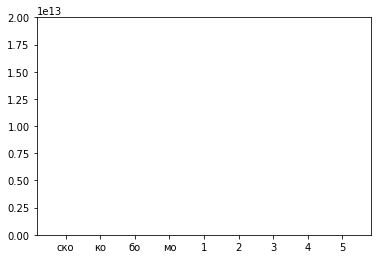

In [9]:
fig, ax = plt.subplots()

ax.set_ylim((0, 2e13))

bars = ax.bar(onames, np.zeros(len(onames)))

Функция вычисления очередного кадра

In [10]:
def animate(i):
    powers = bandpower(data[i*sampling_rate:(i+1)*sampling_rate], sampling_rate, octaves)
    for rect, h in zip(bars.patches, powers):
        rect.set_height(h)
    return bars.patches

Конструктор анимации в matplotlib

In [11]:
anim = animation.FuncAnimation(fig, animate,
                               frames=len(data)//sampling_rate, interval=1000, blit=True)

Отрисовка анимации в Jupyter

In [12]:
HTML(anim.to_jshtml())